# 利用 torch.nn 实现前馈神经网络解决二分类任务

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

## 1 手动生成二分类任务的数据集

In [2]:
num_train, num_test,num_inputs, num_hiddens, num_outputs = 7000, 3000, 200, 100, 2
data1 = torch.tensor(np.random.normal(1, 4, [num_train+num_test, num_inputs]), dtype=torch.float)
label1 = torch.ones(num_train+num_test, dtype=torch.long)
data2 = torch.tensor(np.random.normal(-1, 4, [num_train+num_test, num_inputs]), dtype=torch.float)
label2 = torch.zeros(num_train+num_test, dtype=torch.long)
# 划分训练集测试集
train_data = torch.cat((data1[:num_train,:], data2[:num_train,:]),0)
train_label = torch.cat((label1[:num_train], label2[:num_train]),0)
test_data = torch.cat((data1[num_train:,:], data2[num_train:,:]),0)
test_label = torch.cat((label1[num_train:], label2[num_train:]),0)

## 2 采用 torch.utils.data.DataLoader 读取小批量数据

In [3]:
batch_size = 256
train_data_load = torch.utils.data.TensorDataset(train_data, train_label)
train_iter = torch.utils.data.DataLoader(train_data_load, batch_size, shuffle=True)
test_data_load = torch.utils.data.TensorDataset(test_data, test_label)
test_iter = torch.utils.data.DataLoader(test_data_load, batch_size, shuffle=True)

## 3 模型定义及参数初始化

In [4]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
    )

In [5]:
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

## 4 定义交叉熵损失函数

In [6]:
loss = nn.CrossEntropyLoss()

## 5 定义随机梯度下降函数

In [7]:
lr = 0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

## 6 计算模型在测试数据集上的准确率

In [8]:
def evaluate_accuracy(data_inter,net,loss):
    acc_num,n = 0.0,0
    test_l_sum = 0.0
    for X,y in data_inter:
        acc_num+=(net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X),y).sum()
        test_l_sum+=l.item()
        n += y.shape[0]
    return acc_num/n,test_l_sum/n

## 7 模型训练，保存训练集和验证集的loss

In [9]:
x_l = []
train_loss = []
test_loss = []

In [10]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                optimizer = torch.optim.SGD(net.parameters(), lr=0.1)  # 学习率自适应的优化算法
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter, net,loss)
        x_l.append(epoch + 1)
        train_loss.append(train_l_sum / n)
        test_loss.append(test_l)
        if (epoch+1)%5==0:
            print('epoch %d, train_loss %.6f, train acc %.3f, test_loss %.6f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_l, test_acc))

In [11]:
num_epochs = 30
train(net, train_iter, test_iter, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 5, train_loss 0.000005, train acc 1.000, test_loss 0.000009, test acc 1.000
epoch 10, train_loss 0.000002, train acc 1.000, test_loss 0.000007, test acc 1.000
epoch 15, train_loss 0.000001, train acc 1.000, test_loss 0.000007, test acc 1.000
epoch 20, train_loss 0.000001, train acc 1.000, test_loss 0.000009, test acc 1.000
epoch 25, train_loss 0.000001, train acc 1.000, test_loss 0.000007, test acc 1.000
epoch 30, train_loss 0.000001, train acc 1.000, test_loss 0.000006, test acc 1.000


## 8 绘制loss曲线

In [12]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    plt.plot(x_l, train_loss, label=u'Train Loss')
    plt.legend()
    p2 = plt.plot(x_l, test_loss, label=u'Test Loss')
    plt.legend()
    plt.show()

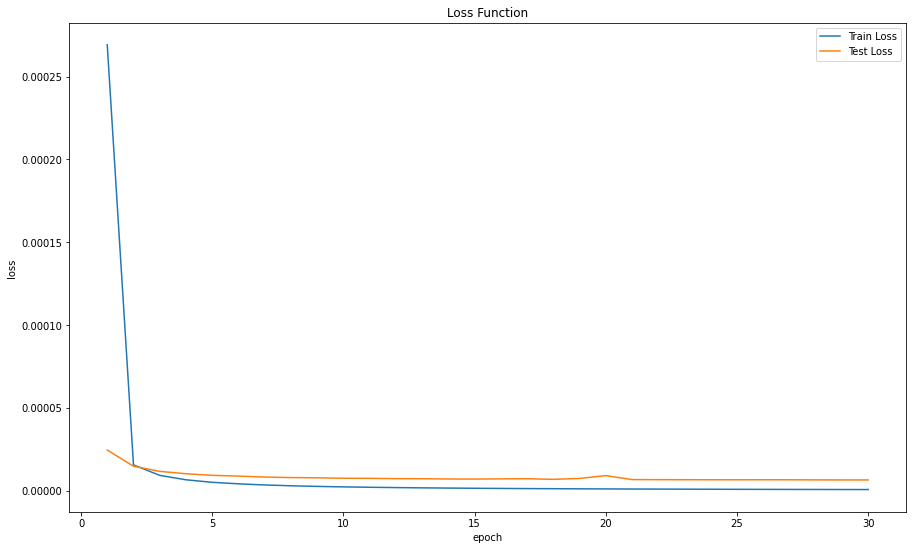

In [13]:
Draw_Loss_Curve()